# Preface

### Attribution and copyright
This analysis is based upon the Global Terrorism Database (GTD) maintained by the National Consortium for the Study of Terrorism and Responses to Terrorism (START). Unless otherwise noted, all data used in this analysis of from the GTD:

**National Consortium for the Study of Terrorism and Responses to Terrorism (START), University of Maryland. (2018). The Global Terrorism Database (GTD) [Data file]. Retrieved from https://www.start.umd.edu/gtd**

This dataset and associated reference materials are also subject to the following copyright: **Copyright University of Maryland 2018**


### License
The author has been granted a *non-transferable* right and license to access the GTD solely for non-commercial research and analysis. Accordingly, all original data files, reference materials, and excerpts of these files or references are not included alongside the analysis. Where the author made use of direct excerpts of the data, the code to view these excerpts will be included, but the excerpts themselves will not be included.

If you have a license to access the GTD, you can re-create these excerpts by cloning this repository, installing the project requirements (you may use the `make requirements` command), placing a copy of the full GTD dataset in the `data/raw/` directory, and re-running the notebooks with the excerpt-creating code uncommented.

### Continuation
This notebook is a continuation of the work begun in the `1_global_terrorism_import_eda_features` notebook. In that notebook we imported, explored, and processed the dataset into a format ready for machine learning. In this notebook we will run that machine learning in order to create a system capable of identifying which terrorist groups are responsible for which attacks.

In [1]:
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.dummy
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import skopt
import skopt.plots
import skopt.space
import skopt.utils
import tqdm

%matplotlib inline

In [2]:
# set up a clean plotting style
sns.set_style('whitegrid')

# make figures a little high-res (and larger in Jupyter)
plt.rc('figure', dpi=120)

In [3]:
SEED = 0

In [4]:
data_dir = Path('../data/processed/')
train_df = pd.read_pickle(data_dir / 'train_df.pkl')
test_df = pd.read_pickle(data_dir / 'test_df.pkl')
unknown_df = pd.read_pickle(data_dir / 'unknown_df.pkl')

# Getting a baseline
As a first step towards building a powerful machine learning system to identify the perpetrators behind terrorist attacks across the globe, we will establish the following:

1. A few "dummy" modeling approaches. The first approach will represent the approach we would take if we had no predictive information, only the target values, and then beyond that we will select at least one high-bias, simple machine learning technique and apply it with minimal data preprocessing. This technique will let us get a sense of how easy it is for ML to beat the initial baseline as well as how easy it is for ML to overfit.

* Performance metrics. These are functions that map a set of labels and a set of corresponding predictions to a continuous scalar value (number) that represents how good the predictions are.

* A standard out-of-sample testing methodlogy. This means either splitting off some of the training data to use as a "validation set" or engaging in some form of cross-validation.

We will then combine these components to get a few baseline scores: the in-sample "training" performand and pseudo-out-of-sample "validation" performance of each of our dummy approaches.

We will use the following components:
1. Prior probability dummy regression (predicting the probability of a perpetrator being responsible for an incident as the percentage of previous incidents that that perpetrator was responsible for), and Logistic Regression (a simple linear model) trained on all the predictive variables that are not missing values.

* Cross-entropy (a measurement of the difference between the distribution of predictions and the distributions of the labels) and top-1 classification accuracy (which is simply the average rate at which the group which is predicted to be most likely to have perpetrated an incident is actually the group that perpetrated it). We will work with both of these metrics because it is both important that the probabilities our models assign roughly correspond to the actual frequency with which those predictions are correct (this property is also often called "calibration") and to measure how frequently our model is "right" in assigning a single label to an unknown value (which is presumably what it will be used for: labeling the "unknown" perpetrators with our best guess of who it probably was). The first objective is measured effectively by cross-entropy, and the second by top-1 accuracy. It is also good to note that our models will be trained to minimize cross-entropy, not misclassification error, since the non-differentiability of misclassification error as an objective function prohibits us from designing learning algorithms which minimize it in a computationally feasible way.

* Five-fold cross-validation. This technique has the advantage of allowing us to train our model on a larger portion of the data and test on a smaller portion at the same degree of uncertainty / noise in our performance measurements, due to the fact that we repeat the process of training and testing multiple times. It costs many times as much computation, but this tradeoff will generally be worth it on datasets as small as this one (<100k rows to train on).

In [5]:
# DEFINEING CROSS VALIDATION

# we will again split our data via date rather than
# by row to somewhat mitigate the effects of some incidents
# being highly related to others
cv = sklearn.model_selection.KFold(5, shuffle=True, random_state=SEED)
train_df_dates = train_df['date'].unique()
date_splits = cv.split(train_df_dates)
row_splits = [(train_df.index[train_df['date'].isin(train_df_dates[train_idx])], 
               train_df.index[train_df['date'].isin(train_df_dates[test_idx])])
              for train_idx, test_idx in date_splits]

def cross_val_predict(model, train_features, train_target):
    """Uses the kfold cross validation above to get out-of-sample
    predictions for every data point in the training set."""
    predictions = pd.DataFrame(0, index=train_target.index, columns=train_target.cat.categories)
    for train_index, val_index in tqdm.tqdm(row_splits):
        model.fit(train_features.loc[train_index, :], 
                  train_target.loc[train_index].cat.codes)
        predictions.loc[val_index, :] = model.predict_proba(train_features.loc[val_index, :])
    return predictions

def cross_val_score(model, train_features, train_target):
    """Uses the kfold cross validation above to get a list of ten validation
    scores for both crossentropy and accuracy."""
    predictions = cross_val_predict(model, train_features, train_target)
    crossentropy_scores = [sklearn.metrics.log_loss(train_target.loc[val_index].cat.codes, 
                                                    predictions.loc[val_index])
                           for _, val_index in row_splits]
    accuracy_scores = [predictions.loc[val_index].idxmax(axis=1).eq(train_target.loc[val_index]).mean()
                       for _, val_index in row_splits]
    return crossentropy_scores, accuracy_scores

def in_sample_score(model, train_features, train_target):
    """Gets in-sample crossentropy and accuracy scores."""
    model.fit(train_features, train_target.cat.codes)
    predictions = pd.DataFrame(model.predict_proba(train_features),
                               index=train_target.index, columns=train_target.cat.categories)
    crossentropy = sklearn.metrics.log_loss(train_target.cat.codes, predictions)
    accuracy = predictions.idxmax(axis=1).eq(train_target).mean()
    return crossentropy, accuracy

# look at the shape of our row splits
[(train.shape, val.shape) for train, val in row_splits]

[((30074,), (7548,)),
 ((30105,), (7517,)),
 ((30251,), (7371,)),
 ((30185,), (7437,)),
 ((29873,), (7749,))]

In [6]:
# should we drop claim variables? probably! unknown acts are hardly ever claimed.
unknown_df['claimed'].eq(1).mean(), train_df['claimed'].eq(1).mean()

(0.0039494470774091624, 0.3352825474456435)

In [7]:
# getting features and targets

# define variables which cannot be used as features
# e.g. the label, guncertain (which relates to the label)
non_feature_cols = ['date',      # datetime not understood by models 
                    # target info
                    'gname',
                    'guncertain1', 
                    'guncertain_has_other_levels', 
                    
                    # drop claims because unknown perpetrator
                    # incidents don't have claims
                    'claimed', 
                    'claim_has_other_levels', 
                    'claimmode', 
                    'compclaim',
                    ]
features = train_df.columns.difference(non_feature_cols)

# we will one-hot encode features, standard scale continuous features, 
# and sorts everything alphabetically to prepare it for general ML work
categorical_types = ['category', 'bool']
train_continuous_features = train_df[features].select_dtypes(exclude=categorical_types).copy()
train_categorical_features = train_df[features].select_dtypes(include=categorical_types).copy()
scaler = sklearn.preprocessing.StandardScaler()
train_continuous_features[:] = scaler.fit_transform(train_continuous_features)
train_categorical_features = pd.get_dummies(train_categorical_features, dummy_na=True)
train_features = pd.concat([train_continuous_features, train_categorical_features], axis=1).sort_index(axis=1)

test_continuous_features = test_df[features].select_dtypes(exclude=categorical_types).copy()
test_categorical_features = test_df[features].select_dtypes(include=categorical_types).copy()
test_continuous_features[:] = scaler.transform(test_continuous_features)
test_categorical_features = pd.get_dummies(test_categorical_features, dummy_na=True)
test_features = pd.concat([test_continuous_features, test_categorical_features], axis=1).sort_index(axis=1)

train_target = train_df['gname']
test_target = test_df['gname']

In [8]:
# setting up baseline models
dummy_classifier = sklearn.dummy.DummyClassifier(strategy='prior')
logistic_regression_classifier = sklearn.linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                                                         random_state=SEED, max_iter=100)

dummy_crossentropies, dummy_accuracies = cross_val_score(dummy_classifier,
                                                         train_features,
                                                         train_target)
print(f'The dummy baseline for crossentopy is {np.mean(dummy_crossentropies):.4f}'
      f' +/- {np.std(dummy_crossentropies):.4f}')
print(f'The dummy baseline for top1 accuracy is {np.mean(dummy_accuracies):.4f}'
      f' +/- {np.std(dummy_accuracies):.4f}')

100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


The dummy baseline for crossentopy is 2.6216 +/- 0.0194
The dummy baseline for top1 accuracy is 0.3068 +/- 0.0090


In [9]:
lr_baseline_crossentropies, lr_baseline_accuracies = cross_val_score(logistic_regression_classifier,
                                                                     train_features.dropna(axis=1),
                                                                     train_target)
print(f'The lr_baseline baseline for crossentopy is {np.mean(lr_baseline_crossentropies):.4f}'
      f' +/- {np.std(lr_baseline_crossentropies):.4f}')
print(f'The lr_baseline baseline for top1 accuracy is {np.mean(lr_baseline_accuracies):.4f}'
      f' +/- {np.std(lr_baseline_accuracies):.4f}')

  0%|          | 0/5 [00:00<?, ?it/s]/home/luke/Projects/global-terrorism-db/venv/global-terrorism-db/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
 20%|██        | 1/5 [00:16<01:07, 16.93s/it]/home/luke/Projects/global-terrorism-db/venv/global-terrorism-db/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
 40%|████      | 2/5 [00:33<00:50, 16.76s/it]/home/luke/Projects/global-terrorism-db/venv/global-terrorism-db/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
 60%|██████    | 3/5 [00:49<00:33, 16.52s/it]/home/luke/Projects/global-terrorism-db/venv/global-terrorism-db/lib/pyt

The lr_baseline baseline for crossentopy is 0.8013 +/- 0.0117
The lr_baseline baseline for top1 accuracy is 0.6928 +/- 0.0062


In [10]:
lr_insample_crossentropy, lr_insample_accuracy = in_sample_score(logistic_regression_classifier,
                                                                 train_features.dropna(axis=1),
                                                                 train_target)
print(f'The lr_baseline baseline for crossentopy is {lr_insample_crossentropy:.4f}.')
print(f'The lr_baseline baseline for top1 accuracy is {lr_insample_accuracy:.4f}.')

/home/luke/Projects/global-terrorism-db/venv/global-terrorism-db/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The lr_baseline baseline for crossentopy is 0.7226.
The lr_baseline baseline for top1 accuracy is 0.7189.


### Baseline conclusions
In running the above baseline work, we find that a simple linear classifier is capable of achieving around 70% accuracy in determining the perpetrator of a terrorist attack, while the baseline best-guess achieves only 30% accuracy. Additionally, we see a substantial reduction in cross-entropy as well in moving from the dummy guess to the linear model. We do see that there appears to be an "upper limit" in-sample accuracy very close to the 70% cross-validated accuracy score, suggesting that there is relatively low overfitting. We see from the cross-entorpy scores that there is some overfitting, though.

All in all, we can be happy that this task seems very tractable for machine learning, and we will focus our model selection search toward more complicated nonlinear models that can handle missing values in their inputs in the hopes that we can eke out increased accuracy. We do not need to worry too much about feature selection or dimensionality reduction at this juncture, since those techniques tend to be used to mitigate overfitting, and we are not currently seeing much overfitting so far.

### Next steps
It would be a valid next step to perform imputation / filling on the columns containing NaNs that we dropped in our first step. However, given that we have a fair amount of data and its types are heterogeneous, it makes sense to try tree-ensemble methods on this data as well, and for those techniques NaN handling should be performed slightly differently, with NaNs being filled as sentinel values or left as NaNs for the built-in NaN handling to deal with.

As a next step, we will try using the LightGBM boosted trees library to improve our performance over the above baseline.

In [11]:
lgb_model = lgb.LGBMClassifier(random_state=SEED, bagging_freq=1, n_estimators=100)
lgb_crossentropy, lgb_accuracy = cross_val_score(lgb_model,
                                                 train_features.fillna(-999),
                                                 train_target)

100%|██████████| 5/5 [01:20<00:00, 16.20s/it]


In [12]:
lgb_crossentropy_insample, lgb_accuracy_insample = in_sample_score(
    lgb_model, train_features.fillna(-999), train_target)

In [13]:
print(f'LGB untuned crossentopy is {np.mean(lgb_crossentropy):.4f}'
      f' +/- {np.std(lgb_crossentropy):.4f}')
print(f'LGB untuned top1 accuracy is {np.mean(lgb_accuracy):.4f}'
      f' +/- {np.std(lgb_accuracy):.4f}')

LGB untuned crossentopy is 0.6869 +/- 0.0162
LGB untuned top1 accuracy is 0.7509 +/- 0.0053


In [14]:
print(f'Insample LGB crossentopy is {lgb_crossentropy_insample:.4f}.')
print(f'Insample LGB top1 accuracy is {lgb_accuracy_insample:.4f}.')

Insample LGB crossentopy is 0.3507.
Insample LGB top1 accuracy is 0.8848.


As we can see, using a boosted trees approach (with stock hyperparemeters) got us a performance improvement of over 5% classification accuracy. We also see that this model overfits much more strongly than the logistic regression model, so there may be some benefit to be had in performing feature selection or tuning.

### Feature importance
Using a boosted tree model also gives us valuable insight into which features are more importance than others for the purpose of predicting terrorist identity. Out of curiosity let's look at which features are important, and then let's see if removing the less important features helps with overfitting.

NOTE: Removing features deemed uninportant by training on the entire training set may cause a slight bias in the performance scores measured by cross-validation over the training set, but in my experience feature importances don't tend to chance too drastically from training set to testing set when there is a good signal-to-noise ratio in the data like we observe here (where a model beats the dummy baseline very significantly).

In [15]:
feature_importance = pd.Series(lgb_model.booster_.feature_importance(importance_type='gain'),
                               index=train_features.columns).sort_values(ascending=False)
feature_importance.head(50)

incident_year                                             114860.318727
region_South Asia                                         101460.406036
region_Sub-Saharan Africa                                  80375.523966
region_Middle East & North Africa                          70060.026605
INT_IDEO_1.0                                               64059.565758
region_Southeast Asia                                      55616.711024
INT_LOG_nan                                                43799.561432
region_South America                                       39086.895519
INT_IDEO_0.0                                               34535.982958
nkill                                                      20924.830624
region_Eastern Europe                                      18364.823322
nwound                                                     15957.803085
INT_LOG_0.0                                                13482.010615
nperps                                                     11854

In [16]:
feature_importance.tail(50)

targsubtype1_Entertainment/Cultural/Stadium/Casino                                      9.768283
targsubtype1_Memorial/Cemetery/Monument                                                 7.649730
targsubtype1_Public Area (garden, parking lot, garage, beach, public building, camp)    7.311507
weapsubtype1_Hands, Feet, Fists                                                         5.678980
targsubtype1_Ambulance                                                                  5.055492
crit2_0.0                                                                               2.790371
INT_MISC_nan                                                                            0.748854
individual_nan                                                                          0.000000
targsubtype1_Legal Services                                                             0.000000
targsubtype1_Clinics                                                                    0.000000
targsubtype1_Demilitarized Zon

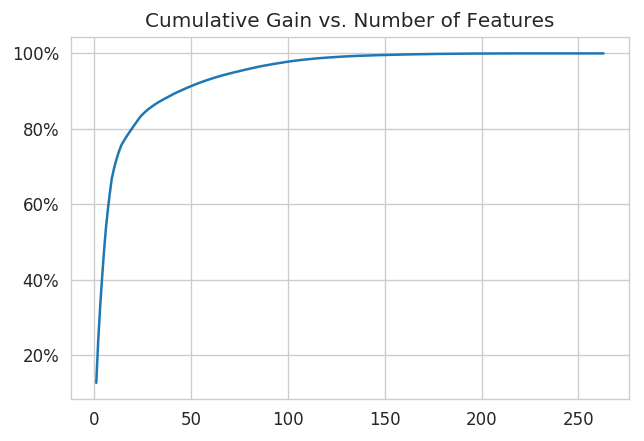

In [17]:
plt.plot(np.arange(feature_importance.shape[0]) + 1, feature_importance.cumsum()/feature_importance.sum())
plt.title('Cumulative Gain vs. Number of Features')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

It seems that we get almost all of the total information gain from the first 100 to 150 features. Let's try restricting ourselves to the first 80 features.

In [18]:
selected_features = feature_importance[:80].index.tolist()
lgb_crossentropy, lgb_accuracy = cross_val_score(lgb_model,
                                                 train_features[selected_features].fillna(-999),
                                                 train_target)

100%|██████████| 5/5 [00:58<00:00, 11.67s/it]


In [19]:
lgb_crossentropy_insample, lgb_accuracy_insample = in_sample_score(
    lgb_model, train_features[selected_features].fillna(-999), train_target)

In [20]:
print(f'LGB untuned crossentopy is {np.mean(lgb_crossentropy):.4f}'
      f' +/- {np.std(lgb_crossentropy):.4f}')
print(f'LGB untuned top1 accuracy is {np.mean(lgb_accuracy):.4f}'
      f' +/- {np.std(lgb_accuracy):.4f}')

LGB untuned crossentopy is 0.7130 +/- 0.0143
LGB untuned top1 accuracy is 0.7417 +/- 0.0051


In [21]:
print(f'Insample LGB crossentopy is {lgb_crossentropy_insample:.4f}.')
print(f'Insample LGB top1 accuracy is {lgb_accuracy_insample:.4f}.')

Insample LGB crossentopy is 0.3764.
Insample LGB top1 accuracy is 0.8716.


Interestingly, we find that there is almost no change in the in-sample scores even on a much lower-dimensional dataset, and a decrease in out-of-sample performance rather than an increase. We will thus avoid using these selected features and instead stick to the full feature set.

# Tuning
While feature selection may not have improved model performance, choosing a better set of model hyperparameters will almost assuredly boost our performance above what the stock parameters achieve. One of the challenges of working with a boosted trees model, however, is that there are a large number of hyperparameters that can be adjusted, and coming up with a strategy to optimize them effectively can be difficult.

Random grid search is frequently used when an exhaustive search of different hyperparameter configurations is not possible. To take a slightly more sophisticated approach, we will be using Gaussian process regression to model the hyperparameter search and select which configurations to test. This approach falls under the unbrella of Sequential Model Based Optimization. We will be using the scikit-optimize package to run GP regression.

In [22]:
search_space = [
    skopt.space.Integer(2, 127, name='num_leaves'),
    skopt.space.Real(1e-2, .5, 'log-uniform', name='learning_rate'),
    skopt.space.Real(0.3, 1.0, name='colsample_bytree'),
    skopt.space.Real(0.3, 1.0, name='subsample'),
    skopt.space.Integer(1, 100, name='min_child_samples'),
]

@skopt.utils.use_named_args(search_space)
def objective(**params):
    params = {**dict(bagging_freq=1, random_state=0), **params}
    model = lgb.LGBMClassifier(**params)
    xent, _ = cross_val_score(model, train_features.fillna(-999), train_target)
    return np.mean(xent)

In [23]:
res_gp = skopt.gp_minimize(objective, search_space, n_calls=100, n_random_starts=30)

100%|██████████| 5/5 [01:55<00:00, 23.30s/it]


(0.6, 1.0)

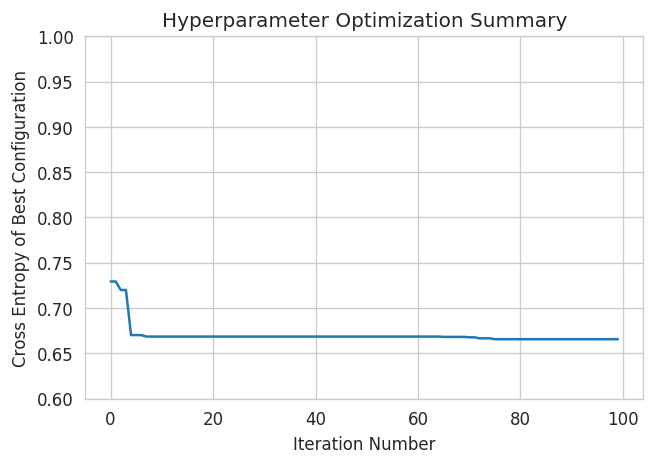

In [24]:
convergence = pd.Series(res_gp.func_vals).cummin()
plt.plot(convergence)
plt.ylabel('Cross Entropy of Best Configuration')
plt.xlabel('Iteration Number')
plt.title('Hyperparameter Optimization Summary')
plt.ylim(.6, 1.0)

In [25]:
selected_configuration = dict(zip([x.name for x in search_space], res_gp.x))
selected_configuration

{'num_leaves': 64,
 'learning_rate': 0.0826879903924392,
 'colsample_bytree': 0.7673698117683464,
 'subsample': 0.850392109200204,
 'min_child_samples': 75}

# Testing
While the purpose of this project is to try and infer the perpetrators for incidents in which the perpetrators are unknown, we cannot actually test the efficacy of our machine learning system unless we actually know the perpetrators of the indicents we test on. We thus separated out 30% of our labeled data into the test set, which we will now run a single test on with our best model: the tuned LightGBM gradient boosted machine.

In [26]:
tuned_params = {**dict(random_state=SEED, bagging_freq=1), **selected_configuration}
model = lgb.LGBMClassifier(**tuned_params)
model.fit(train_features.fillna(-999), train_target.cat.codes)
predictions = pd.DataFrame(model.predict_proba(test_features.fillna(-999)),
                               index=test_target.index, columns=test_target.cat.categories)
crossentropy = sklearn.metrics.log_loss(test_target.cat.codes, predictions)
accuracy = predictions.idxmax(axis=1).eq(test_target).mean()
print(f'Final test crossentopy is {crossentropy:.4f}.')
print(f'Final test top1 accuracy is {accuracy:.4f}.')

Final test crossentopy is 0.6364.
Final test top1 accuracy is 0.7675.


In [27]:
# let's also look at the prediction frequency
predictions.idxmax(axis=1).value_counts(normalize=True)

OTHER_GROUP                                       0.288277
Taliban                                           0.155862
Islamic State of Iraq and the Levant (ISIL)       0.114244
Al-Shabaab                                        0.061782
Boko Haram                                        0.044490
New People's Army (NPA)                           0.037925
Communist Party of India - Maoist (CPI-Maoist)    0.034760
Maoists                                           0.032122
Revolutionary Armed Forces of Colombia (FARC)     0.027843
Kurdistan Workers' Party (PKK)                    0.023857
Houthi extremists (Ansar Allah)                   0.020516
Al-Qaida in the Arabian Peninsula (AQAP)          0.014537
Tehrik-i-Taliban Pakistan (TTP)                   0.013892
Donetsk People's Republic                         0.013365
Liberation Tigers of Tamil Eelam (LTTE)           0.011079
Al-Qaida in Iraq                                  0.010375
Fulani extremists                                 0.0102

In [28]:
# and we can also peek at the true frequency now, too
test_target.value_counts(normalize=True)

OTHER_GROUP                                       0.293376
Taliban                                           0.137632
Islamic State of Iraq and the Levant (ISIL)       0.108265
Al-Shabaab                                        0.059965
Boko Haram                                        0.044725
Communist Party of India - Maoist (CPI-Maoist)    0.034467
New People's Army (NPA)                           0.031243
Maoists                                           0.029777
Kurdistan Workers' Party (PKK)                    0.026260
Tehrik-i-Taliban Pakistan (TTP)                   0.023329
Revolutionary Armed Forces of Colombia (FARC)     0.022860
Houthi extremists (Ansar Allah)                   0.022040
Al-Qaida in the Arabian Peninsula (AQAP)          0.018464
Liberation Tigers of Tamil Eelam (LTTE)           0.012075
Muslim extremists                                 0.012075
Al-Qaida in Iraq                                  0.011841
Donetsk People's Republic                         0.0111

# Testing takeaways
In the end, we were able to create a system that was able to correctly infer the group responsible for a terrorist incident over 75% of the time on data it had never seen before. While we did restrict our system to predicting from the top 30 terrorist groups, only roughly 30% of terrorist incidents are carried out by groups other than those 30, so this system at face value offers a great deal of real-world value. It is also good to note that we achieved a low cross-entropy score and that the distribution of groups in the predictions and true labels were very similar, suggesting that our model is fairly well calibrated!

### The unknown

As well as the system performed on our test set, we cannot be certain that it will function the same way when it comes to inferring the groups behind the "unknown" incidents. To assume that these incidents follow the same distribution as the labeled incidents in which the GTD curators were able to identify the perpetrator would be a grave mistake. However, some information is better than none, so as long as we don't assume that every prediction is most likely correct, we can still check and see if our system uncovers any intersting patterns in the uknown data.

In [29]:
unknown_continuous_features = unknown_df[features].select_dtypes(exclude=categorical_types).copy()
unknown_categorical_features = unknown_df[features].select_dtypes(include=categorical_types).copy()
unknown_continuous_features[:] = scaler.transform(unknown_continuous_features)
unknown_categorical_features = pd.get_dummies(unknown_categorical_features, dummy_na=True)
unknown_features = pd.concat([unknown_continuous_features, unknown_categorical_features], axis=1).sort_index(axis=1)
predicted_unknown_groups = predictions = pd.DataFrame(model.predict_proba(unknown_features.fillna(-999)),
                                                      index=unknown_features.index, columns=test_target.cat.categories).idxmax(axis=1)

predicted_unknown_groups.value_counts(normalize=True)

OTHER_GROUP                                      0.374408
Muslim extremists                                0.305065
Maoists                                          0.250580
Separatists                                      0.052570
Fulani extremists                                0.017125
Palestinian Extremists                           0.000168
Abu Sayyaf Group (ASG)                           0.000034
Revolutionary Armed Forces of Colombia (FARC)    0.000034
Chechen Rebels                                   0.000017
dtype: float64

# Takeaways on the unknown data
Compared to the test set, the predictions for the unknown set are vastly different. It seems that ISIL and the Taliban, which account for 25% of test-set incidents and 27% of test-set predictions, have completely dissapeared from the predictions on the unknown set. This suggests that perhaps these major groups have a distinctive "fingerprint" that our model learned effectively, and that these groups were clearly not responsible for the "unknown" incidents. Indeed, few specific named groups place highly in the predictions on the "unknown" set, with generic terms like "muslim extremists" and "separatists" taking the top places in terms of predicted frequency.

In conclusion, it seems that our model is suggesting that the "unknown" incidents are very likely not attributable to any major group. It could be that our model actually can tell with accuracy whether these unknown incidents were caused by "muslim extremests" as opposed to "separatists" or "maoists," but given that those categories make up so little of the labeled data, we should not assume that the performance metrics we observed on the test data will hold for these. All we can really conclude is that our model was one of the best we could learn from the data we had and that it found some interesting patterns around specific groups not be accountable for the "unknown" incidents.

# Future work
No good scientific analysis is complete without some reflection on what could be done differently to improve the process. I have identified the following major areas for improvement:

* Run more tuning iterations. 30 iterations is enough to get a sense of the value of running hyperparameter optimization, but running more iterations may lead us to finding a better set of hyperparameters that improve performance.

* Don't drop high cardinality categorical fields. We saw in our feature importance printout that region-based locations were quite important features, suggesting that the country and nationality features may be helpful to performance. It would make sense to implement some sort of rebinning or truncating process by which we could keep 20-50 of the 100+ levels of theese variables in our dataset, rather than dropping them. An easy way to go about this would be to keep only the top K levels by total number of incidents in that country in the training data.

* Extract information from text fields. We dropped over 20 different fields containing text that could be useful and predictive. We should instead either use keyword matching to extract some information from these fields or engage in a more fulsome NLP approach and encode this text (as TF-IDF features or similar) for use in ML modeling.

* Tune more hyperparameters. We barely scratched the surface of the hyperparameters that could be tuned in our GBM. For example, regularization, ensemble size, and learning rate can all be altered to try and find a better configuration.

* Stack and ensemble. By using cross-validation to get pseudo-out-of-sample predictions, we can train models to learn from other models' predictions in a process called "stacking." This would allow us to combine the predictions of a number of well-performing GBM configurations or combine our tree-based GBM with another model like a multilayer perceptron via stacking under a simpler model like Logistic Regression. Using a simpler model like Logistic Regression can also have a positive effect on calibration.

* Learn a confidence measure. When labeling the "unknown" data, it would be extremely helpful to get a sense of how confident the model is in its prediction at each datapoint beyond the confidence implied by its predicted probability. We can train a model on the outputs of our model and on some of the key features that predicts how likely our model is to be correct on that particular sample. This model could the be used to estimate our confidence around our predictions on the unknown data.